In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o
import scipy as sp

## Result Gathering

In [55]:
main_df = None
directory = "Effort_Estimation_Results_3E_v2/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cas.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Eclim.csv
Guacamole-client.csv
Hadoop.csv
Hawtio.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Rest-assured.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Tika.csv
Traccar.csv


In [56]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,2,2,NaN,8,1.000000,15.00000,4.13952,2.477916,12.48,42.435515
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,1,NaN,346,0.225434,1.00000,179.03424,107.076009,2229.76,519.589347
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,2,0.707107,35,1.000000,1.00000,18.11040,10.840124,189.60,113.234791
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,13,4.018895,194,0.185567,3.71134,100.38336,60.060503,1232.64,353.641141
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,1,136,50.585661,1938,0.004128,1.00000,1002.79872,597.273303,12673.28,1634.048307


In [57]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [58]:
len(main_df)

775

In [59]:
main_df['refactoring_perc_time_taken'] = main_df['refactoring_perc'] * main_df['time_taken']

In [60]:
def plotGraph(y_test,y_pred,y_test_str,y_pred_str,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

def plotGraphandSave(y_test,y_pred,y_test_str,y_pred_str,regressorName,img_name):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
        
    plt.figure(figsize=(15,15))
    plt.scatter(range(len(y_test)), y_test, color='blue', label=y_test_str)
    plt.scatter(range(len(y_pred)), y_pred, color='red', label=y_pred_str)
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.savefig(f'model_prediction_images/{img_name}.png')
    plt.show()
    return





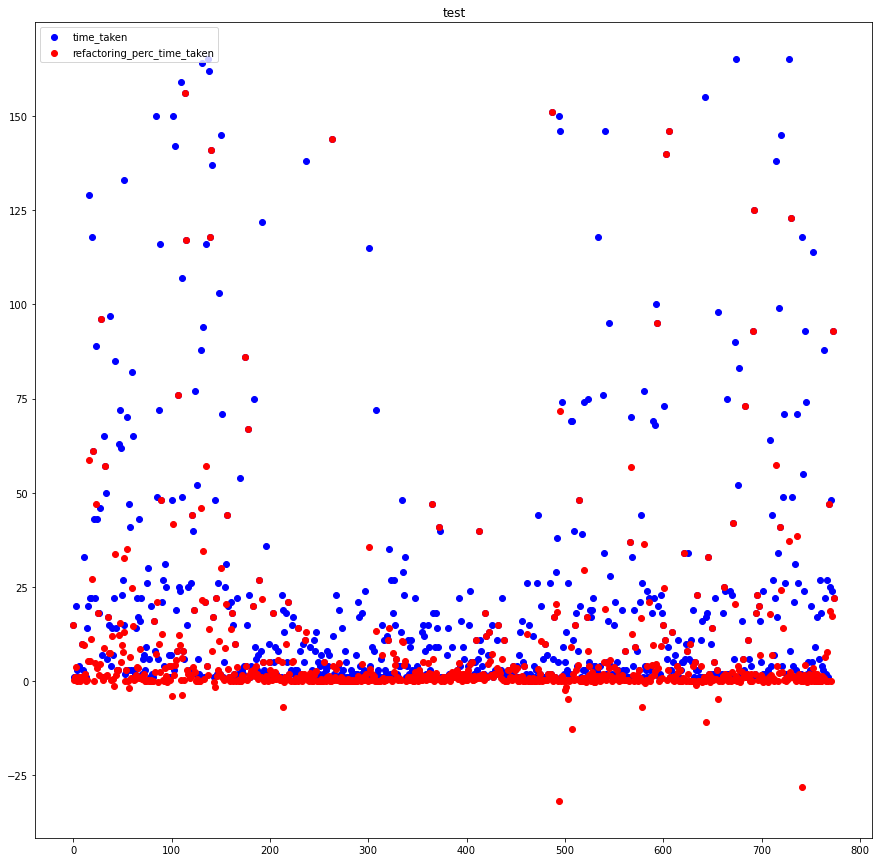

In [61]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],'time_taken','refactoring_perc_time_taken','test')

In [62]:
main_df = main_df[main_df['refactoring_perc_time_taken'] > 0]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 40]
#main_df = main_df[main_df['refactoring_perc_time_taken'] <= 20]

#main_df = main_df[main_df['time_taken_final'] <= 60]
#main_df = main_df[main_df['time_taken_final'] > 2]

In [63]:
main_df['refactoring_perc_time_taken'].value_counts()

1.000000    27
2.000000    23
3.000000    11
4.000000     6
5.000000     6
            ..
0.545455     1
1.351016     1
5.953846     1
1.438889     1
1.685144     1
Name: refactoring_perc_time_taken, Length: 597, dtype: int64

In [64]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [65]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



In [66]:
main_df = main_df.fillna(0)

In [67]:
bins = [0, 16,32, 40]
labels = [0,1,2]
main_df['refactoring_perc_time_taken_bin'] = pd.cut(main_df['refactoring_perc_time_taken'], bins=bins, labels=labels)

{'whiskers': [<matplotlib.lines.Line2D at 0x2116ec16f28>,
 'caps': [<matplotlib.lines.Line2D at 0x2116ec0e6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2116ec16dd8>],
 'medians': [<matplotlib.lines.Line2D at 0x2116ec0eda0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2116ec08160>],
 'means': []}

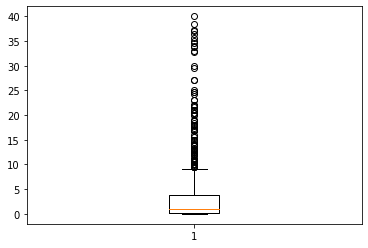

In [68]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

(array([649.,   0.,   0.,   0.,   0.,  39.,   0.,   0.,   0.,  12.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

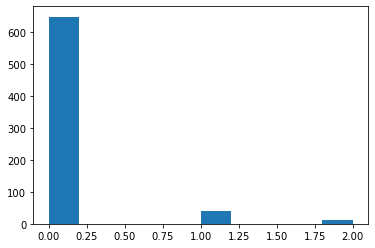

In [69]:
plt.hist(main_df['refactoring_perc_time_taken_bin'])

In [70]:
main_df['refactoring_perc_time_taken_bin'].value_counts()

0    649
1     39
2     12
Name: refactoring_perc_time_taken_bin, dtype: int64

In [71]:
main_df.dtypes

kmean_label                           int64
time_taken_mean                     float64
time_taken_min                      float64
time_taken_max                      float64
time_taken_q10                      float64
                                     ...   
geneticP_time_taken                 float64
softwareMaintenance_time_taken      float64
fuzzy_time_taken                    float64
time_taken_final                    float64
refactoring_perc_time_taken_bin    category
Length: 208, dtype: object

In [72]:
#main_df['refactoring_perc_time_taken_bin'] = main_df['refactoring_perc_time_taken_bin'].astype('string')

#main_df['refactoring_perc_time_taken_bin'] = main_df['refactoring_perc_time_taken_bin'].astype('category')

In [73]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,cocomoII_time_taken,geneticP_time_taken,softwareMaintenance_time_taken,fuzzy_time_taken,time_taken_final,refactoring_perc_time_taken_bin
0,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,0.000000,8,1.000000,15.000000,4.13952,2.477916,12.48,42.435515,7.0,0
1,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,0.000000,346,0.225434,0.225434,179.03424,107.076009,2229.76,519.589347,0.0,0
2,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,0.707107,35,1.000000,1.000000,18.11040,10.840124,189.60,113.234791,0.0,0
3,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,4.018895,194,0.185567,3.711340,100.38336,60.060503,1232.64,353.641141,1.0,0
4,5,12.712987,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,50.585661,1938,0.004128,0.012384,1002.79872,597.273303,12673.28,1634.048307,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,12,27.087805,1.0,165.0,1.0,2.0,2.0,3.0,5.6,15.0,...,1.964427,615,0.053659,0.053659,318.22560,190.190193,3994.40,761.687072,0.0,0
1,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,0.866025,16,0.750000,18.750000,8.27904,4.955729,64.96,67.284406,5.0,1
2,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,2.946898,1696,0.004127,0.198113,877.57824,523.020584,11085.76,1495.349884,9.0,0
3,6,24.474860,1.0,167.0,1.0,2.0,4.0,5.0,10.0,16.0,...,0.000000,535,0.725234,17.405607,276.83040,165.484354,3469.60,694.272395,4.0,1


(array([533.,  63.,  30.,  23.,  18.,  13.,   6.,   2.,   7.,   5.]),
 array([1.20827670e-04, 4.00010874e+00, 8.00009666e+00, 1.20000846e+01,
        1.60000725e+01, 2.00000604e+01, 2.40000483e+01, 2.80000362e+01,
        3.20000242e+01, 3.60000121e+01, 4.00000000e+01]),
 <a list of 10 Patch objects>)

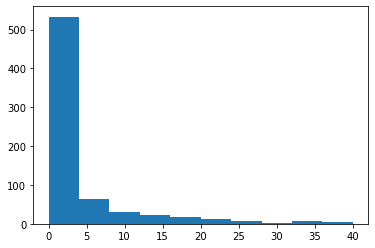

In [74]:
plt.hist(main_df['refactoring_perc_time_taken'])

(array([346., 114.,  40.,  33.,  28.,  17.,   5.,  13.,   5.,  11.,  11.,
          3.,   8.,   6.,   7.,   2.,   5.,   7.,   3.,   3.,   7.,   4.,
          2.,   0.,   4.,   0.,   1.,   1.,   0.,   2.,   0.,   0.,   2.,
          2.,   2.,   1.,   2.,   1.,   1.,   1.]),
 array([1.20827670e-04, 1.00011781e+00, 2.00011479e+00, 3.00011177e+00,
        4.00010874e+00, 5.00010572e+00, 6.00010270e+00, 7.00009968e+00,
        8.00009666e+00, 9.00009364e+00, 1.00000906e+01, 1.10000876e+01,
        1.20000846e+01, 1.30000816e+01, 1.40000785e+01, 1.50000755e+01,
        1.60000725e+01, 1.70000695e+01, 1.80000665e+01, 1.90000634e+01,
        2.00000604e+01, 2.10000574e+01, 2.20000544e+01, 2.30000514e+01,
        2.40000483e+01, 2.50000453e+01, 2.60000423e+01, 2.70000393e+01,
        2.80000362e+01, 2.90000332e+01, 3.00000302e+01, 3.10000272e+01,
        3.20000242e+01, 3.30000211e+01, 3.40000181e+01, 3.50000151e+01,
        3.60000121e+01, 3.70000091e+01, 3.80000060e+01, 3.90000030e+01,
      

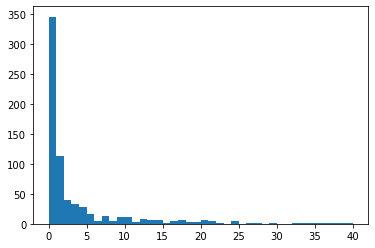

In [75]:
plt.hist(main_df['refactoring_perc_time_taken'],bins=40)

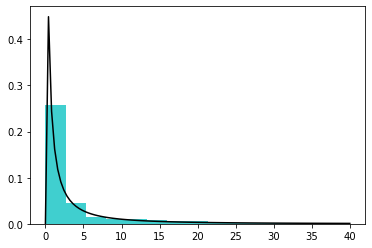

In [76]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=15, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

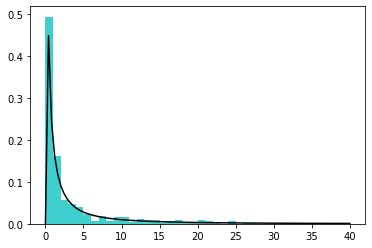

In [77]:
s, loc, scale = sp.stats.lognorm.fit(main_df['refactoring_perc_time_taken'], floc=0)
estimated_mu = np.log(scale)
estimated_sigma = s


plt.hist(main_df['refactoring_perc_time_taken'], bins=40, density=True, color='c', alpha=0.75)
xmin = main_df['refactoring_perc_time_taken'].min()
xmin = 0
xmax = main_df['refactoring_perc_time_taken'].max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.lognorm.pdf(x, s, scale=scale)
plt.plot(x, pdf, 'k')

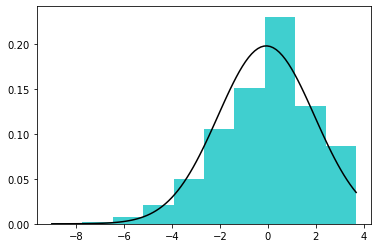

In [78]:
logdata = np.log(main_df['refactoring_perc_time_taken'])
plt.hist(logdata, bins=10, density=True, color='c', alpha=0.75)
xmin = logdata.min()
xmax = logdata.max()
x = np.linspace(xmin, xmax, 100)
pdf = sp.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
plt.plot(x, pdf, 'k')

In [79]:
len(main_df)

700

In [80]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [81]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [82]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [83]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc',
 'cocomoII_time_taken',
'geneticP_time_taken',
'softwareMaintenance_time_taken',
'fuzzy_time_taken',
'time_taken_final',
'refactoring_perc_time_taken'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [84]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [85]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken_bin')
Y_col = ['refactoring_perc_time_taken_bin']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [86]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,11.000000,11.0,11.0,0.000000,8.000000,8.0,8.0,0.000000,2.000000,2.0,...,58.000000,58.0,58.0,0.000000,17.000000,17.0,17.0,0.000000,85.000000,61.000000
1,12.000000,12.0,12.0,0.000000,8.000000,8.0,8.0,0.000000,1.000000,1.0,...,68.000000,68.0,68.0,0.000000,17.000000,17.0,17.0,0.000000,3.000000,78.000000
2,30.000000,30.0,30.0,0.000000,29.000000,29.0,29.0,0.000000,1.000000,1.0,...,103.000000,103.0,103.0,0.000000,1.000000,1.0,1.0,0.000000,78.000000,322.000000
3,23.250000,5.0,63.0,20.780782,20.666667,4.0,64.0,21.993112,2.000000,1.0,...,121.333333,37.0,320.0,98.919006,1.000000,1.0,1.0,0.000000,57.583333,222.666667
4,7.833333,0.0,31.0,11.027514,7.833333,1.0,21.0,7.444746,1.166667,1.0,...,63.500000,8.0,125.0,36.335557,10.333333,1.0,17.0,8.238858,54.333333,88.000000


In [87]:
y.head()

,refactoring_perc_time_taken_bin
0,0
1,0
2,0
3,0
4,0


## Feature Engineering

In [88]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,18 mins 49 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,5 months and 17 days !!!
H2O_cluster_name:,H2O_from_python_tanji_twikdl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.973 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [89]:
important_var = ['cbo_std',
 'uniqueWordsQty_min',
 'rfc_std',
 'totalMethods_min',
 'uniqueWordsQty_mean',
 'num_dependency_mean',
 'loc_min',
 'num_line_affected_mean',
 'uniqueWordsQty_max',
 'assignmentsQty_min',
 'loc_mean',
 'rfc_max',
 'cbo_mean',
 'rfc_mean',
 'lambdasQty_mean',
 'variablesQty_std',
 'maxNestedBlocks_mean',
 'numbersQty_mean',
 'stringLiteralsQty_min',
 'cbo_max']

In [90]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
full['refactoring_perc_time_taken_bin'] = full['refactoring_perc_time_taken_bin'].asfactor()
train,test = full.split_frame(ratios=[0.7], seed=16)


#x = train.columns
x = important_var
y = "refactoring_perc_time_taken_bin"
#x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [91]:
full.shape

(700, 163)

In [92]:
train[x].types

{'cbo_std': 'real',
 'uniqueWordsQty_min': 'int',
 'rfc_std': 'real',
 'totalMethods_min': 'int',
 'uniqueWordsQty_mean': 'real',
 'num_dependency_mean': 'real',
 'loc_min': 'int',
 'num_line_affected_mean': 'real',
 'uniqueWordsQty_max': 'int',
 'assignmentsQty_min': 'int',
 'loc_mean': 'real',
 'rfc_max': 'int',
 'cbo_mean': 'real',
 'rfc_mean': 'real',
 'lambdasQty_mean': 'real',
 'variablesQty_std': 'real',
 'maxNestedBlocks_mean': 'real',
 'numbersQty_mean': 'real',
 'stringLiteralsQty_min': 'int',
 'cbo_max': 'int'}

In [93]:
train[y].types

{'refactoring_perc_time_taken_bin': 'enum'}

In [94]:
aml = H2OAutoML(max_models=25, seed=16, balance_classes=True)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
07:01:25.799: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████| 100%


In [95]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse
DeepLearning_grid__2_AutoML_20220220_070125_model_2,0.552362,1.10506,0.328627,0.107995
DeepLearning_grid__2_AutoML_20220220_070125_model_3,0.58014,0.810402,0.331467,0.10987
DeepLearning_grid__3_AutoML_20220220_070125_model_2,0.586226,0.432591,0.2974,0.0884469
DeepLearning_grid__1_AutoML_20220220_070125_model_2,0.594752,1.08185,0.331108,0.109633
DeepLearning_grid__1_AutoML_20220220_070125_model_3,0.606471,1.44588,0.336668,0.113346
DeepLearning_1_AutoML_20220220_070125,0.608068,0.435761,0.290695,0.0845035
DeepLearning_grid__1_AutoML_20220220_070125_model_1,0.619788,0.610516,0.287971,0.0829272
DeepLearning_grid__3_AutoML_20220220_070125_model_1,0.634249,1.19202,0.324092,0.105036
DeepLearning_grid__2_AutoML_20220220_070125_model_1,0.654947,0.53596,0.275093,0.0756763
GBM_grid__1_AutoML_20220220_070125_model_2,0.666667,0.416481,0.256608,0.0658475


In [96]:
model = h2o.get_model(lb[0,'model_id'])

In [97]:
model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid__2_AutoML_20220220_070125_model_2


Status of Neuron Layers: predicting refactoring_perc_time_taken_bin, 3-class classification, multinomial distribution, CrossEntropy loss, 3,753 weights/biases, 53.6 KB, 1,546,720 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,20,Input,5,,,,,,,,,
1,,2,50,RectifierDropout,0,0,0,0.0509327,0.0685778,0,0.0592965,0.44696,0.229365,0.484095
2,,3,50,RectifierDropout,0,0,0,0.0658282,0.133248,0,-0.045959,0.399241,1.02414,0.607938
3,,4,3,Softmax,,0,0,0.155703,0.251591,0,-0.59649,1.40377,-0.398073,0.196364




ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.07361177576373261
RMSE: 0.27131490147747617
LogLoss: 0.24982065751169077
Mean Per-Class Error: 0.08803247848800994
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,Error,Rate
0,455.0,6.0,0.0,0.013015,6 / 461
1,0.0,458.0,0.0,0.000000,0 / 458
2,116.0,0.0,346.0,0.251082,116 / 462
3,571.0,464.0,346.0,0.088342,"122 / 1,381"



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.911658
1,2,0.958001
2,3,1.000000



ModelMetricsMultinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.10799542595629347
RMSE: 0.328626575243533
LogLoss: 1.1050591955938514
Mean Per-Class Error: 0.5523620149433599
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,Error,Rate
0,427.0,21.0,13.0,0.073753,34 / 461
1,19.0,4.0,1.0,0.833333,20 / 24
2,6.0,0.0,2.0,0.750000,6 / 8
3,452.0,25.0,16.0,0.121704,60 / 493



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.878296
1,2,0.977688
2,3,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.87819004,0.0600985,0.9292929,0.94949496,0.8080808,0.86734694,0.8367347
1,auc,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,err,0.12180994,0.0600985,0.07070707,0.05050505,0.1919192,0.13265306,0.1632653
3,err_count,12.0,5.91608,7.0,5.0,19.0,13.0,16.0
4,logloss,1.1072133,0.77084744,0.4290603,0.7829519,1.0477029,0.8493778,2.426973
5,max_per_class_error,0.8933333,0.15347819,1.0,0.8,1.0,1.0,0.6666667
6,mean_per_class_accuracy,0.48406172,0.15140906,0.43040934,0.72978723,0.33257577,0.41545895,0.5120773
7,mean_per_class_error,0.5159383,0.15140906,0.5695906,0.27021277,0.66742426,0.5845411,0.4879227
8,mse,0.108089715,0.052256193,0.06449027,0.047368865,0.16592412,0.11000641,0.15265894
9,pr_auc,NaN,0.0,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_classification_error,training_auc,training_pr_auc
0,,2022-02-20 07:07:39,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-02-20 07:07:39,2 min 14.900 sec,68706 obs/sec,10.0,1,13810.0,0.722830,5.030877,0.218255,0.601738,NaN,NaN
2,,2022-02-20 07:07:44,2 min 19.984 sec,99371 obs/sec,380.0,38,524780.0,0.405588,0.928326,0.753872,0.168718,NaN,NaN
3,,2022-02-20 07:07:49,2 min 25.071 sec,102592 obs/sec,770.0,77,1063370.0,0.317411,0.501614,0.849257,0.104272,NaN,NaN
4,,2022-02-20 07:07:53,2 min 29.638 sec,103612 obs/sec,1120.0,112,1546720.0,0.271315,0.249821,0.889861,0.088342,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,stringLiteralsQty_min,1.000000,1.000000,0.089907
1,totalMethods_min,0.969890,0.969890,0.087200
2,num_dependency_mean,0.761477,0.761477,0.068462
3,assignmentsQty_min,0.759895,0.759895,0.068320
4,lambdasQty_mean,0.698135,0.698135,0.062767
5,uniqueWordsQty_min,0.643720,0.643720,0.057875
6,maxNestedBlocks_mean,0.607942,0.607942,0.054658
7,numbersQty_mean,0.580247,0.580247,0.052168
8,cbo_mean,0.566215,0.566215,0.050907
9,num_line_affected_mean,0.544203,0.544203,0.048928


In [98]:
preds = model.predict(test[x])

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [99]:
preds

predict,p0,p1,p2
0,1,5.45058e-10,7.91468e-10
0,0.999986,1.44224e-05,3.87496e-26
0,1,1.14866e-11,3.27322e-36
1,2.53453e-05,0.999975,1.98672e-15
0,0.985353,0.0146474,4.1165e-20
0,1,2.85947e-09,8.6139e-35
0,1,7.58941e-09,1.68012e-40
0,0.716302,0.283698,1.509e-18
0,1,8.36107e-13,6.23998e-27
0,0.998734,0.00126629,2.85157e-13


In [100]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

0    192
1     12
2      3
Name: predict, dtype: int64

In [101]:
test.head()

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken_bin
25,25,25,0,32,32,32,0,1,1,1,0,65,65,65,0,9,9,9,0,23,23,23,0,1,1,1,0,18,18,18,0,4,4,4,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,7,7,7,0,3,3,3,0,1,1,1,0,4,4,4,0,2,2,2,0,0,0,0,0,4,4,4,0,0,0,0,0,46,46,46,0,265,265,265,0,6,6,6,0,0,0,0,0,0,0,0,0,10,10,10,0,0,0,0,0,80,80,80,0,14,14,14,0,49,49,49,0,32,32,32,0,48,48,48,0,2,2,2,0,0,0,0,0,0,0,0,0,1,1,1,0,166,166,166,0,1025,1025,1025,0,51,321,0
15,15,15,0,10.5,7,14,4.94975,2.5,1,4,2.12132,14,12,16,2.82843,5,1,9,5.65685,10.5,7,14,4.94975,0,0,0,0,10.5,7,14,4.94975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.5,27,34,4.94975,91,60,122,43.8406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.5,23,26,2.12132,13,8,18,7.07107,11,7,15,5.65685,0,0,0,0,10,6,14,5.65685,0,0,0,0,0,0,0,0,1.5,0,3,2.12132,3.5,3,4,0.707107,71.5,65,78,9.19239,1,1,1,0,26.5,95.5,1
2,2,2,0,2,2,2,0,1,1,1,0,2,2,2,0,0,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,16,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,9,0,1024,1024,1024,0,168,13,0
8,8,8,0,6,6,6,0,1,

In [102]:
print(len(test))
print(len(pd_preds))

207
207


In [103]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken_bin']

In [104]:
pd_preds.head()

,predict,p0,p1,p2,actual_time_taken
0,0,1.000000,5.450583e-10,7.914683e-10,0
1,0,0.999986,1.442236e-05,3.874956e-26,1
2,0,1.000000,1.148664e-11,3.273223e-36,0
3,1,0.000025,9.999747e-01,1.986725e-15,2
4,0,0.985353,1.464737e-02,4.116496e-20,0


In [105]:
pd_preds.loc[(pd_preds.predict < 0),'predict']=1

In [106]:
pd_preds

,predict,p0,p1,p2,actual_time_taken
0,0,1.000000,5.450583e-10,7.914683e-10,0
1,0,0.999986,1.442236e-05,3.874956e-26,1
2,0,1.000000,1.148664e-11,3.273223e-36,0
3,1,0.000025,9.999747e-01,1.986725e-15,2
4,0,0.985353,1.464737e-02,4.116496e-20,0
...,...,...,...,...,...
202,0,1.000000,4.773090e-10,2.641312e-10,0
203,0,1.000000,5.787584e-14,1.314773e-14,0
204,0,0.999999,8.172255e-09,6.529715e-07,0
205,0,1.000000,8.455409e-08,8.099082e-08,0



Testing Results of the trained model: 

Accuracy :  0.8405797101449275

Confusion Matrix :
 [[174  11   3]
 [ 15   0   0]
 [  3   1   0]]

Classification Report :
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       188
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         4

    accuracy                           0.84       207
   macro avg       0.30      0.31      0.31       207
weighted avg       0.82      0.84      0.83       207



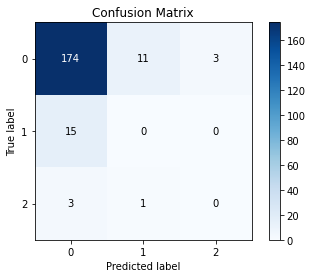

In [107]:
# For Classification
import scikitplot as skplt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix

# Predict with the best model.
#predicted_y = model.predict(valid[featureColumns])

#predicted_data = predicted_y.as_data_frame()
#valid_dataset = valid.as_data_frame()

# Evaluate the skill of the Trained model
acc = accuracy_score(pd_preds['actual_time_taken'], pd_preds['predict'])
classReport = classification_report(pd_preds['actual_time_taken'], pd_preds['predict'])
confMatrix  = confusion_matrix(pd_preds['actual_time_taken'], pd_preds['predict']) 
        
print(); print('Testing Results of the trained model: ')
print(); print('Accuracy : ', acc)
print(); print('Confusion Matrix :\n', confMatrix)
print(); print('Classification Report :\n',classReport)

# Confusion matrix
skplt.metrics.plot_confusion_matrix(pd_preds['actual_time_taken'], pd_preds['predict'])

In [198]:
visualization = pd_preds[pd_preds['predict'] <= 20]
visualization = pd_preds[pd_preds['actual_time_taken'] <= 20]


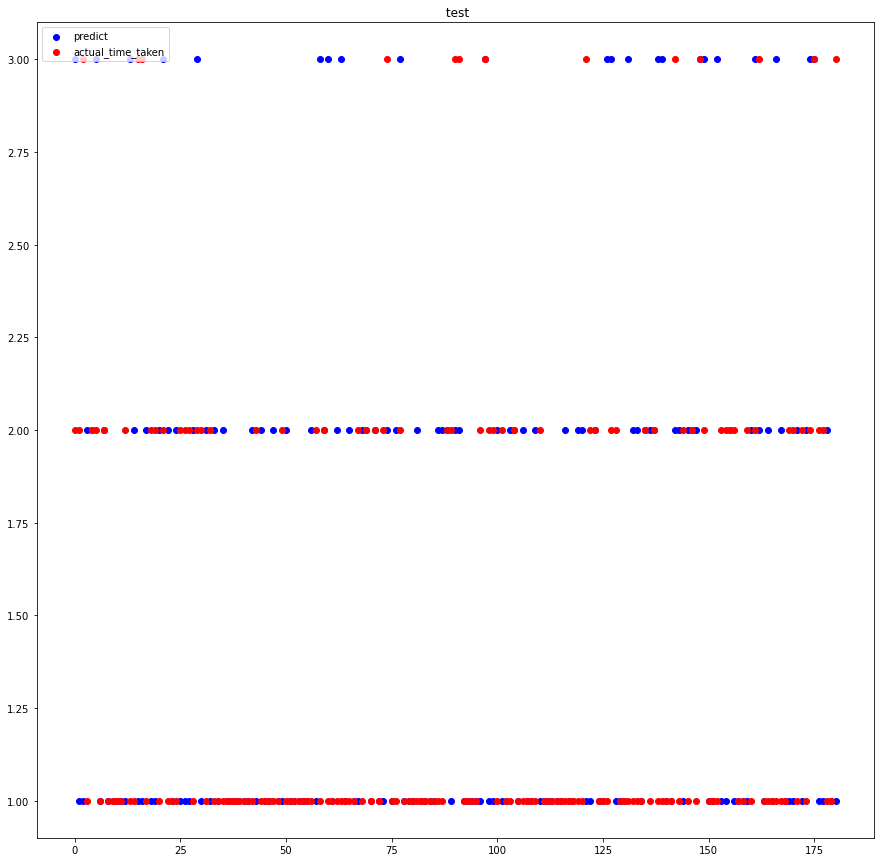

In [199]:
plotGraph(visualization['predict'], visualization['actual_time_taken'],'predict','actual_time_taken',' test')

In [534]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

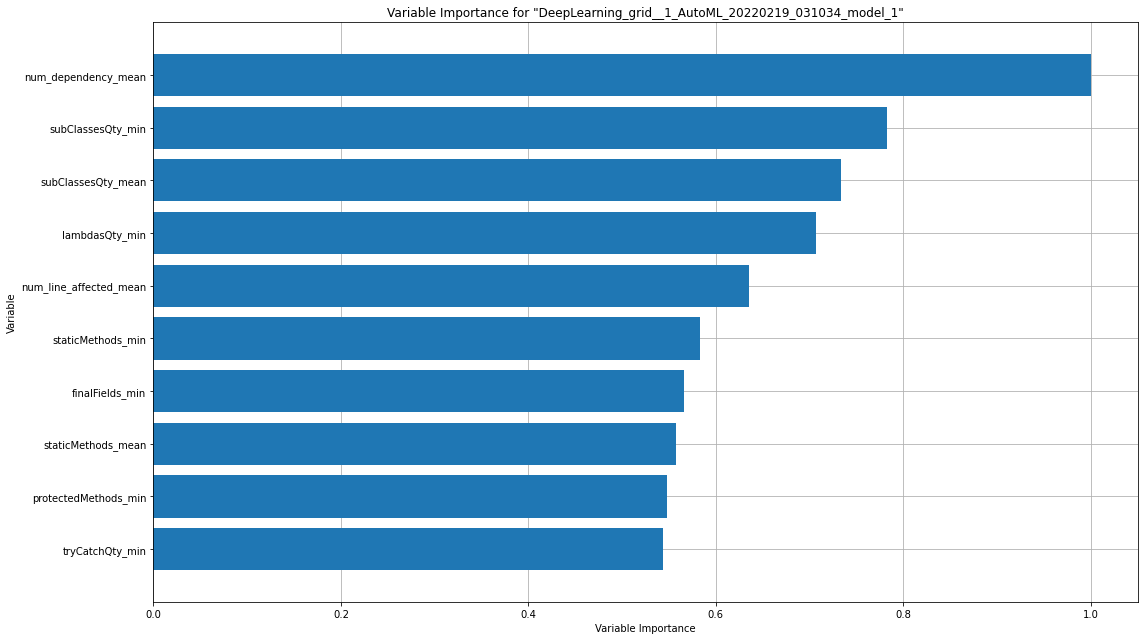

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

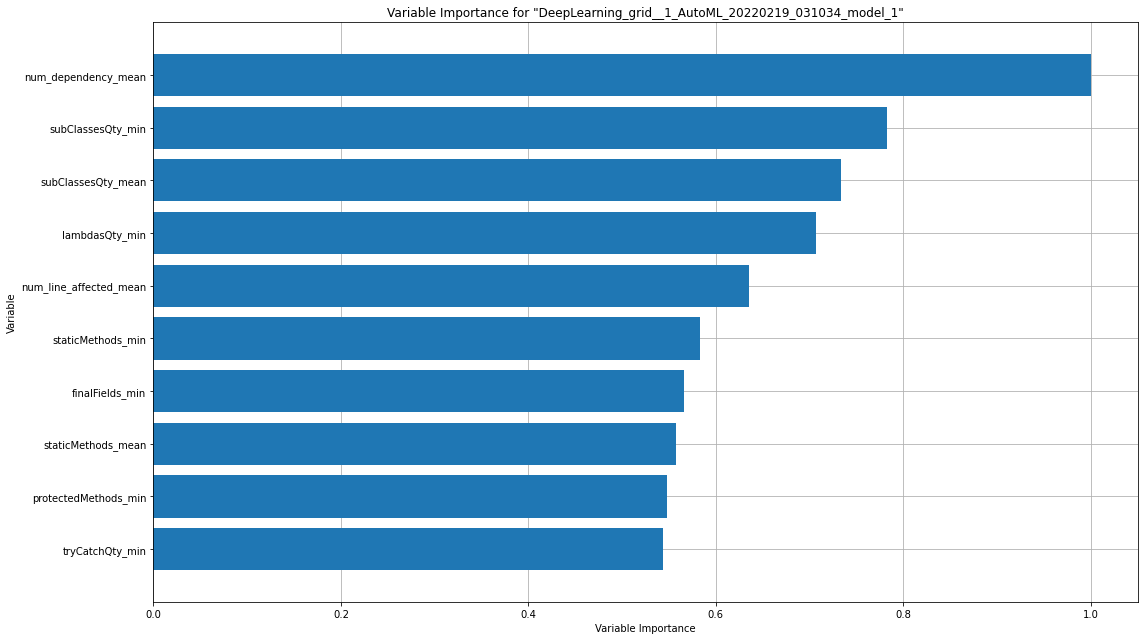

In [162]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [40]:
## Test calling of model

model_path = "models/EffortEstimationModelv2/SmallWithinADay_23_DeepLearning_grid__3_AutoML_20220213_032636_model_2"
saved_model = h2o.load_model(model_path)

In [41]:
preds_read_model = saved_model.predict(test)
pd_preds_read_model = preds_read_model.as_data_frame()
pd_test = test.as_data_frame()
#pd_preds = preds.as_data_frame()
pd_preds_read_model['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

deeplearning prediction progress: |███████████████████████████████████████| 100%


In [42]:
pd_preds_read_model.head()

,predict,actual_time_taken
0,0.395690,1.097143
1,0.156619,1.628571
2,2.908174,7.411236
3,3.828710,0.268657
4,1.830154,3.480952


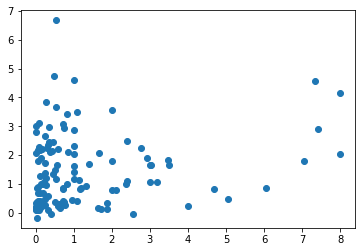

In [43]:
import matplotlib.pyplot as plt
plt.scatter(pd_preds_read_model['actual_time_taken'], pd_preds_read_model['predict'])

In [ ]:
plotGraph(pd_preds_read_model['predict'], pd_preds_read_model['actual_time_taken'],'predict','actual_time_taken',' test')

In [ ]:
#aml.explain_row(test, row_index=0)

In [ ]:
#h2o.shutdown()